# Аналитика в Яндекс.Афише

Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):
Uid — уникальный идентификатор пользователя
Device — категория устройства пользователя
Start Ts — дата и время начала сессии
End Ts — дата и время окончания сессии
Source Id — идентификатор рекламного источника, из которого пришел пользователь
Таблица orders (информация о заказах):
Uid — уникальный id пользователя, который сделал заказ
Buy Ts — дата и время заказа
Revenue — выручка Яндекс.Афиши с этого заказа
Таблица costs (информация о затратах на маркетинг):
source_id — идентификатор рекламного источника
dt — дата
costs — затраты на этот рекламный источник в этот день

### Цель и описание задачи

Помочь маркетологам оптимизировать маркетинговые затраты.В распоряжении есть данные с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта ,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

# Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
from datetime import date, timedelta

## 1.1. Загрузим данные о визитах, заказах и расходах в переменные.

In [2]:
visits = pd.read_csv(r"/datasets/visits_log.csv")
orders = pd.read_csv(r"/datasets/orders_log.csv")
costs = pd.read_csv(r"/datasets/costs.csv")

first_list=[visits,orders,costs]

for i in first_list:
    print(i.info())
    display(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


### даты в наших данных необходимо привести к формату date

## 1.2. Приведем значения Start Ts,End Ts,Buy Ts и dt в формат даты и времени.

In [3]:
visits["Start Ts"]=pd.to_datetime(visits["Start Ts"])
visits["End Ts"]=pd.to_datetime(visits["End Ts"])
print(visits.info())

orders["Buy Ts"]=pd.to_datetime(orders["Buy Ts"])
print(orders.info())

costs["dt"]=pd.to_datetime(costs["dt"])
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


### Данные загружены. Сделана проверка на отсутствие пропусков и соответствие соответствующим типам. По итогам , ряд исходной информации переведен в формат даты и времени.

# Шаг 2. Постройте отчёты и посчитайте метрики

## 2.1. Продукт

Посчитаем сколько людей пользуется продуктом в месяц

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Uid')

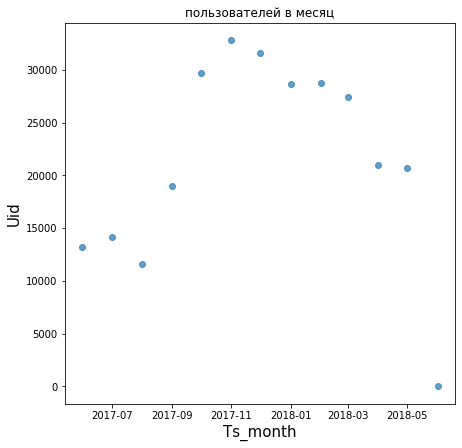

In [4]:
visits['Ts_month'] = visits['End Ts'].astype('datetime64[M]')

visit_month_group=visits.groupby(['Ts_month']).agg({'Uid':'nunique'}).reset_index()
#display(visit_month_group)
#выведем медианное значение 
#display(visit_month_group['Uid'].median())


plt.figure(figsize=(7,7))
plt.plot( "Ts_month", 'Uid',linestyle='none', data=visit_month_group, marker='o', alpha=0.7)
plt.title('пользователей в месяц')
plt.xlabel("Ts_month",fontsize=15)
plt.ylabel('Uid',fontsize=15)

Посчитаем сколько людей пользуется продуктом в день

Text(0, 0.5, 'Uid')

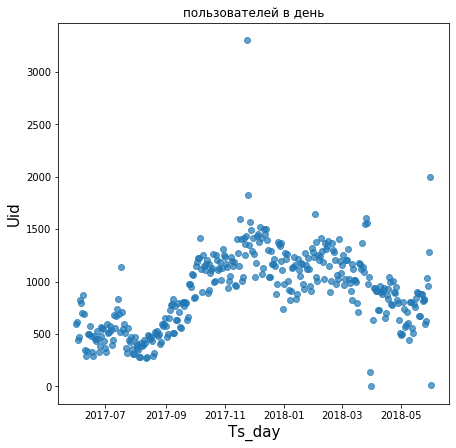

In [5]:
visits['Ts_day'] = visits['End Ts'].astype('datetime64[D]')
visit_day_group=visits.groupby(['Ts_day']).agg({'Uid':'nunique'}).reset_index()
#display(visit_day_group)
#выведем медианное значение 
#display(visit_day_group['Uid'].median())

plt.figure(figsize=(7,7))
plt.plot( 'Ts_day', 'Uid',linestyle='none', data=visit_day_group, marker='o', alpha=0.7)
plt.title('пользователей в день')
plt.xlabel('Ts_day',fontsize=15)
plt.ylabel('Uid',fontsize=15)

Посчитаем сколько людей пользуется продуктом в неделю

Text(0, 0.5, 'Uid')

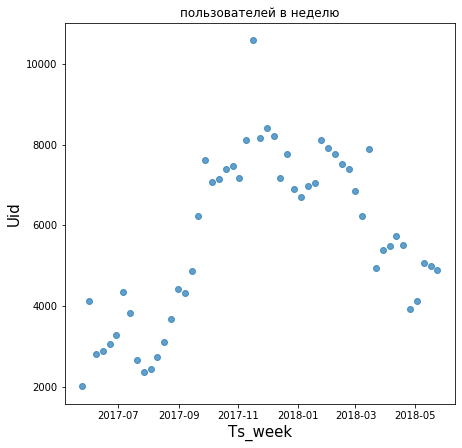

In [6]:
visits['Ts_week']  = (pd.to_datetime(visits['End Ts'], unit='d') - pd.to_timedelta(visits['End Ts'].dt.dayofweek, unit='d'))
visits['Ts_week'] = visits['Ts_week'].astype('datetime64[W]')
visit_week_group=visits.groupby(['Ts_week']).agg({'Uid':'nunique'}).reset_index()
#display(visit_week_group)
#выведем медианное значение 
#display(visit_week_group['Uid'].median())

plt.figure(figsize=(7,7))
plt.plot( 'Ts_week', 'Uid',linestyle='none', data=visit_week_group, marker='o', alpha=0.7)
plt.title('пользователей в неделю')
plt.xlabel('Ts_week',fontsize=15)
plt.ylabel('Uid',fontsize=15)

### Полученые данные удовлетворяют логике: кол-во пользователей за дни, недели и месяци пропорциональны временным отрезкам, без сильных выбросов. Однако стоит отметить, что  в зимний период наблюдается возрастание кол-ва человек.

 Рассчитаем cколько сессий в день

In [7]:
visits_group_session=visits.groupby(['Ts_day']).agg({'End Ts':'count'}).reset_index()
display(visits_group_session)
#выведем медианное значение 
display(visits_group_session['End Ts'].median())

,Ts_day,End Ts
0,2017-06-01,659
1,2017-06-02,660
2,2017-06-03,477
3,2017-06-04,505
4,2017-06-05,893
...,...,...
360,2018-05-28,1150
361,2018-05-29,1040
362,2018-05-30,1403
363,2018-05-31,2256


995.0

### Около тысяи сессий в день. При этом мы выяснили, что в день у нас около тысячи пользователей. Данные адекватны.

Рассчитаем сколько длится одна сессия

         Device              End Ts  Source Id            Start Ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         Uid   Ts_month     Ts_day    Ts_week  session_lenghth  
0       16879256277535980062 2017-12-01 2017-12-20 2017-12-14        18.000000

5.0

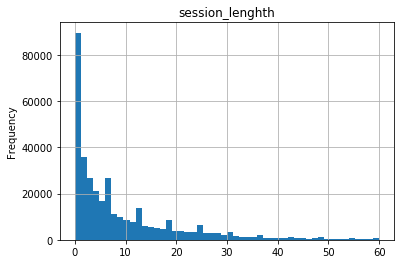

In [8]:
visits['session_lenghth']  = (visits['End Ts']-visits['Start Ts'])/ np.timedelta64(1,'m')
print(visits)
#выведем медианное значение 
display(visits['session_lenghth'].median())


visits['session_lenghth'].plot(kind='hist', title='session_lenghth', range=(0, 60), bins=50,grid=True)
plt.show()


### Средняя продолжительность сессии 5 минут. Этого достаточно, если ты знаешь, чего хочешь. Однако частвсего люди "зависают" на сайте по пол часа, выбирая подходящие варианты, либо сразу выходят.

### Определим как часто люди возвращаются

Разделим данные на когорты, равные месяцу и найдем период существования каждой когорты

In [9]:
first_activity_date = visits.groupby(['Uid'])['Start Ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='Uid')



visits['Ts_first_month'] = visits['first_activity_date'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['Ts_month'] - visits['Ts_first_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')
display(visits)





,Device,End Ts,Source Id,Start Ts,Uid,Ts_month,Ts_day,Ts_week,session_lenghth,first_activity_date,Ts_first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-20,2017-12-14,18.000000,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-19,2018-02-15,28.000000,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-22,0.000000,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-20,2018-05-10,24.000000,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-27,2017-12-21,0.000000,2017-12-27 14:06:00,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-29,2017-07-20,0.316667,2017-07-29 19:07:00,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-25,2018-01-18,0.316667,2018-01-25 17:38:00,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-03,2018-02-22,0.316667,2018-03-03 10:12:00,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-02,2017-10-26,0.316667,2017-11-02 10:12:00,2017-11-01,0


сгрупируем когорты

In [10]:
cohorts = visits.groupby(['Ts_first_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
display(cohorts)

,Ts_first_month,cohort_lifetime,Uid
0,2017-06-01,0,13259
1,2017-06-01,2,713
2,2017-06-01,3,814
3,2017-06-01,4,909
4,2017-06-01,5,947
...,...,...,...
59,2018-03-01,1,861
60,2018-03-01,2,557
61,2018-04-01,0,15709
62,2018-05-01,0,15266


Найдём исходное количество пользователей в когорте

In [11]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['Ts_first_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})
display(initial_users_count)

,Ts_first_month,cohort_users
0,2017-06-01,13259
10,2017-07-01,13136
19,2017-08-01,10177
28,2017-09-01,16704
34,2017-10-01,25971
41,2017-11-01,27248
46,2017-12-01,25267
51,2018-01-01,22614
55,2018-02-01,22197
58,2018-03-01,20589


Объединим данные по когортам с исходным количеством пользователей в когорте

In [12]:
cohorts = cohorts.merge(initial_users_count,on='Ts_first_month')
display(cohorts)

,Ts_first_month,cohort_lifetime,Uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,2,713,13259
2,2017-06-01,3,814,13259
3,2017-06-01,4,909,13259
4,2017-06-01,5,947,13259
...,...,...,...,...
59,2018-03-01,1,861,20589
60,2018-03-01,2,557,20589
61,2018-04-01,0,15709,15709
62,2018-05-01,0,15266,15266


Рассчитаем Retention Rate

In [13]:
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
display(cohorts)

,Ts_first_month,cohort_lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,2,713,13259,0.053775
2,2017-06-01,3,814,13259,0.061392
3,2017-06-01,4,909,13259,0.068557
4,2017-06-01,5,947,13259,0.071423
...,...,...,...,...,...
59,2018-03-01,1,861,20589,0.041818
60,2018-03-01,2,557,20589,0.027053
61,2018-04-01,0,15709,15709,1.000000
62,2018-05-01,0,15266,15266,1.000000


Построим сводную таблицу 

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
Ts_first_month,,,,,,,,,,,
2017-06-01,1.0,NaN,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.084018,0.040652,0.044951
2017-07-01,1.0,0.056410,0.051309,0.056181,0.058237,0.048188,0.045371,0.073767,NaN,0.049254,NaN
2017-08-01,1.0,0.077036,0.062985,0.062789,0.050113,0.044021,0.065835,0.027906,0.026039,NaN,NaN
2017-09-01,1.0,NaN,0.102550,NaN,0.039392,0.065673,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078703,0.052289,0.038967,0.058873,0.021370,0.020369,NaN,NaN,NaN,NaN
2017-11-01,1.0,NaN,0.044113,0.065069,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055844,0.062136,0.020264,0.019037,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.090254,0.024985,0.020253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.025409,0.020138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


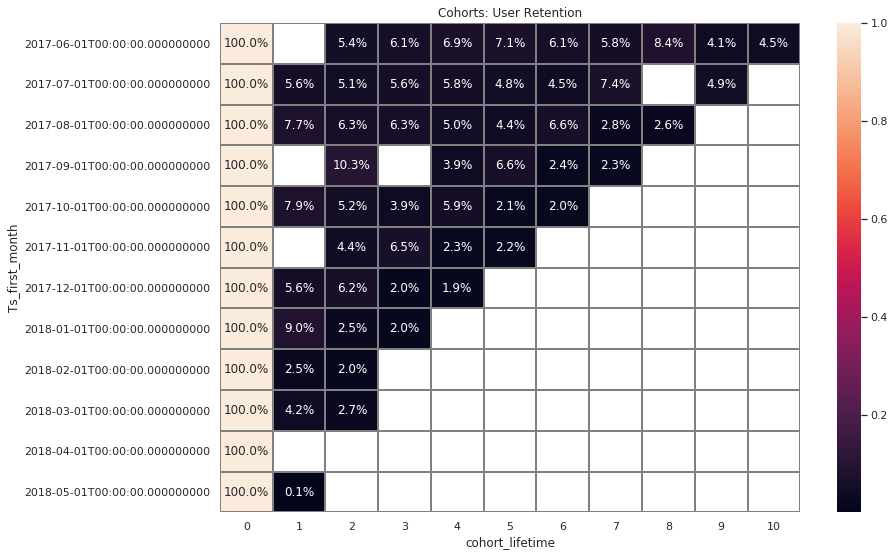

In [14]:
retention_pivot = cohorts.pivot_table(index='Ts_first_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
display(retention_pivot)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

###  Оценив Retention Rate можно сделать вывод, что целом величины имеют низкое значение и маленький разброс. Количество пользователей, которые возвращаются не велико. В подтверждение этого вывода можно отметить, что с каждой новой кагортой уровень рассматриваемого параметра падает. Для увеличения прибыли стоит рассмотреть методику удержания пользователей.

##  2.2 Продажи

Разделим данные о заказах и затратах на рекламу на месячные когорты.

In [15]:
orders['Buy Ts_month'] = orders['Buy Ts'].astype('datetime64[M]')
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

Посчитаем сколько раз покупают за период

In [16]:

orders_period = orders.groupby('Buy Ts_month').agg({'Uid': 'count'}).reset_index()
orders_period.columns=['Buy Ts_month','orders_per_month']
display(orders_period)
#выведем медианное значение 
display(orders_period['orders_per_month'].median())

,Buy Ts_month,orders_per_month
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


4346.0

Выведем среднее число покупок на одного пользователя за пол года

In [17]:
d1=pd.to_datetime("2017-12-01")
orders['delta']=(orders['Buy Ts_month'] -d1)/ np.timedelta64(1, 'D')
orders_1st_unic = orders[orders['delta']<0].groupby('Uid').agg({'Buy Ts': 'count'}).reset_index()
orders_2st_unic = orders[orders['delta']>=0].groupby('Uid').agg({'Buy Ts': 'count'}).reset_index()

print("среднее число покупок на одного пользователя за первые пол года:" ,orders_1st_unic['Buy Ts'].mean())
print("среднее число покупок на одного пользователя за первые пол года:" ,orders_2st_unic['Buy Ts'].mean())



среднее число покупок на одного пользователя за первые пол года: 1.3021816399068513
среднее число покупок на одного пользователя за первые пол года: 1.3363573883161513


### Среднее число покупок на человека за полгода практически не изменилось. В месяц совершается около четырех с половиной тысяч покупок, но большинство пользователей совершает покупку один раз. То есть средства, затраченные на рекламу редко "играют" на долгосрочную перспективу.

Определим средний чек за месяц 

In [18]:
revenue_period = orders.groupby('Buy Ts_month').agg({'Revenue': 'mean'}).reset_index()
display(revenue_period)
#выведем медианное значение 
display(revenue_period['Revenue'].median())

,Buy Ts_month,Revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280
5,2017-11-01,4.783518
6,2017-12-01,5.852139
7,2018-01-01,4.112927
8,2018-02-01,4.840095
9,2018-03-01,5.413930


4.847138904261187

### Средний чек за месяц составляет 4.85 у.е. Принимая во внимания низкий уровень retention, необходимо, чтобы затраты на одну покупку не привышали данную величину.

Получим месяц первой покупки каждого покупателя

In [19]:
first_orders = orders.groupby('Uid').agg({'Buy Ts_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_Ts_month']
display(first_orders.head())

,Uid,first_Ts_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей  за каждый месяц:

In [20]:
new_costumers = first_orders.groupby('first_Ts_month').agg({'Uid': 'nunique'}).reset_index()
new_costumers.columns = ['dt_month', 'new_costumers']
display(new_costumers)

,dt_month,new_costumers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Найдем сколько каждый месяц тратится на привлечение новых клиентов и добавим в эту таблицу кол-во привлеченных человек.

In [21]:
cost_group = costs.groupby(['dt_month']).agg({'costs': 'sum'}).reset_index()
cost_group = pd.merge(cost_group, new_costumers, on='dt_month')
display(cost_group)

,dt_month,costs,new_costumers
0,2017-06-01,18015.00,2023
1,2017-07-01,18240.59,1923
2,2017-08-01,14790.54,1370
3,2017-09-01,24368.91,2581
4,2017-10-01,36322.88,4340
5,2017-11-01,37907.88,4081
6,2017-12-01,38315.35,4383
7,2018-01-01,33518.52,3373
8,2018-02-01,32723.03,3651
9,2018-03-01,30415.27,3533


### Выполним расчет CAC для каждой кагорты 

In [22]:
cost_group['cac'] = (cost_group['costs'] / new_costumers['new_costumers']).round(2)
display(cost_group)

,dt_month,costs,new_costumers,cac
0,2017-06-01,18015.00,2023,8.91
1,2017-07-01,18240.59,1923,9.49
2,2017-08-01,14790.54,1370,10.80
3,2017-09-01,24368.91,2581,9.44
4,2017-10-01,36322.88,4340,8.37
5,2017-11-01,37907.88,4081,9.29
6,2017-12-01,38315.35,4383,8.74
7,2018-01-01,33518.52,3373,9.94
8,2018-02-01,32723.03,3651,8.96
9,2018-03-01,30415.27,3533,8.61


### Примерно 9 у.е. на человека. А средний чек, как мы определили выше, составляет 4.85 у.е. Уже видно, что для окупаемости необходимо привлекать больше клиентов  и удерживать имеющихся.

Построим когорты, добавив месяц первой покупки каждого покупателя в таблицу с заказами

In [23]:
orders_new = pd.merge(orders,first_orders, on='Uid')
display(orders_new.head)

<bound method NDFrame.head of                    Buy Ts  Revenue                   Uid Buy Ts_month  delta  \
0     2017-06-01 00:10:00    17.00  10329302124590727494   2017-06-01 -183.0   
1     2017-06-01 00:25:00     0.55  11627257723692907447   2017-06-01 -183.0   
2     2017-06-01 00:27:00     0.37  17903680561304213844   2017-06-01 -183.0   
3     2017-06-01 00:29:00     0.55  16109239769442553005   2017-06-01 -183.0   
4     2017-06-01 07:58:00     0.37  14200605875248379450   2017-06-01 -183.0   
...                   ...      ...                   ...          ...    ...   
50410 2018-05-31 23:50:00     4.64  12296626599487328624   2018-05-01  151.0   
50411 2018-05-31 23:50:00     5.80  11369640365507475976   2018-05-01  151.0   
50412 2018-05-31 23:54:00     0.30   1786462140797698849   2018-05-01  151.0   
50413 2018-05-31 23:56:00     3.67   3993697860786194247   2018-05-01  151.0   
50414 2018-06-01 00:02:00     3.42     83872787173869366   2018-06-01  182.0   

      fir

Объединим имеющиеся данные по индификатору пользователя, дню совершения покупки и источнику рекламы.

In [24]:
visits_compare=visits[['Device','Ts_day','Uid','Source Id']]
visits_compare.columns=['Device','dt','Uid','source_id']
orders_new['dt'] = orders_new['Buy Ts'].astype('datetime64[D]')
orders_new=orders_new.merge(visits_compare, how='left',left_on=['Uid','dt'], right_on=['Uid','dt']).dropna(subset=['Device'])
display(orders_new)


,Buy Ts,Revenue,Uid,Buy Ts_month,delta,first_Ts_month,dt,Device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,-183.0,2017-06-01,2017-06-01,desktop,1.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,-183.0,2017-06-01,2017-06-01,desktop,2.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,-183.0,2017-06-01,2017-06-01,desktop,2.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,-183.0,2017-06-01,2017-06-01,desktop,2.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,-183.0,2017-06-01,2017-06-01,desktop,3.0
...,...,...,...,...,...,...,...,...,...
63675,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,151.0,2018-05-01,2018-05-31,desktop,2.0
63676,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,151.0,2018-05-01,2018-05-31,touch,4.0
63677,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,151.0,2018-05-01,2018-05-31,desktop,10.0
63678,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,151.0,2018-05-01,2018-05-31,desktop,3.0


### В данной задаче мы будем рассчитывать LTV исходя из ежемесячной выручки, т.к. затраты на привлечения клиента  актуальны только в первый месяц появления новой когорты.

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим прибыль.

In [25]:
order_group = orders_new.groupby(['first_Ts_month','Buy Ts_month']).agg({'Revenue': 'sum'}).reset_index()
display(order_group)

,first_Ts_month,Buy Ts_month,Revenue
0,2017-06-01,2017-06-01,11831.72
1,2017-06-01,2017-07-01,1009.62
2,2017-06-01,2017-08-01,1079.09
3,2017-06-01,2017-09-01,2614.21
4,2017-06-01,2017-10-01,2688.00
...,...,...,...
74,2018-03-01,2018-05-01,2163.50
75,2018-04-01,2018-04-01,11263.65
76,2018-04-01,2018-05-01,2388.24
77,2018-05-01,2018-05-01,14625.90


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

In [26]:
report = pd.merge(order_group, orders_period, on='Buy Ts_month')
display(report.head)

<bound method NDFrame.head of    first_Ts_month Buy Ts_month   Revenue  orders_per_month
0      2017-06-01   2017-06-01  11831.72              2354
1      2017-06-01   2017-07-01   1009.62              2363
2      2017-07-01   2017-07-01  13171.21              2363
3      2017-06-01   2017-08-01   1079.09              1807
4      2017-07-01   2017-08-01    597.57              1807
..            ...          ...       ...               ...
74     2018-02-01   2018-05-01    279.61              4346
75     2018-03-01   2018-05-01   2163.50              4346
76     2018-04-01   2018-05-01   2388.24              4346
77     2018-05-01   2018-05-01  14625.90              4346
78     2018-06-01   2018-06-01      3.42                 1

[79 rows x 4 columns]>

In [27]:
report['age'] = (report['Buy Ts_month'] - report['first_Ts_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
display(report)

,first_Ts_month,Buy Ts_month,Revenue,orders_per_month,age
0,2017-06-01,2017-06-01,11831.72,2354,0
1,2017-06-01,2017-07-01,1009.62,2363,1
2,2017-07-01,2017-07-01,13171.21,2363,0
3,2017-06-01,2017-08-01,1079.09,1807,2
4,2017-07-01,2017-08-01,597.57,1807,1
...,...,...,...,...,...
74,2018-02-01,2018-05-01,279.61,4346,3
75,2018-03-01,2018-05-01,2163.50,4346,2
76,2018-04-01,2018-05-01,2388.24,4346,1
77,2018-05-01,2018-05-01,14625.90,4346,0


Выберем условное "время жизни" когорты,равное 6 месяцам, и рассмотрим данные в этом диапазоне.

In [28]:
d2=pd.to_datetime("2017-12-01")
report['delta']=(report['first_Ts_month'] -d1)/ np.timedelta64(1, 'D')
report=report[report['delta']<=0]
display(report)

cost_group['delta']=(cost_group['dt_month'] -d2)/ np.timedelta64(1, 'D')
cost_group=cost_group[cost_group['delta']<=0]
display(cost_group)

,first_Ts_month,Buy Ts_month,Revenue,orders_per_month,age,delta
0,2017-06-01,2017-06-01,11831.72,2354,0,-183.0
1,2017-06-01,2017-07-01,1009.62,2363,1,-183.0
2,2017-07-01,2017-07-01,13171.21,2363,0,-153.0
3,2017-06-01,2017-08-01,1079.09,1807,2,-183.0
4,2017-07-01,2017-08-01,597.57,1807,1,-153.0
...,...,...,...,...,...,...
68,2017-08-01,2018-05-01,228.41,4346,9,-122.0
69,2017-09-01,2018-05-01,453.22,4346,8,-91.0
70,2017-10-01,2018-05-01,584.55,4346,7,-61.0
71,2017-11-01,2018-05-01,892.28,4346,6,-30.0


,dt_month,costs,new_costumers,cac,delta
0,2017-06-01,18015.00,2023,8.91,-183.0
1,2017-07-01,18240.59,1923,9.49,-153.0
2,2017-08-01,14790.54,1370,10.80,-122.0
3,2017-09-01,24368.91,2581,9.44,-91.0
4,2017-10-01,36322.88,4340,8.37,-61.0
5,2017-11-01,37907.88,4081,9.29,-30.0
6,2017-12-01,38315.35,4383,8.74,0.0


Для объективного сравнения уберем лишние периоды

In [29]:
report=report[report['age']<6]
display(report)

,first_Ts_month,Buy Ts_month,Revenue,orders_per_month,age,delta
0,2017-06-01,2017-06-01,11831.72,2354,0,-183.0
1,2017-06-01,2017-07-01,1009.62,2363,1,-183.0
2,2017-07-01,2017-07-01,13171.21,2363,0,-153.0
3,2017-06-01,2017-08-01,1079.09,1807,2,-183.0
4,2017-07-01,2017-08-01,597.57,1807,1,-153.0
5,2017-08-01,2017-08-01,8055.29,1807,0,-122.0
6,2017-06-01,2017-09-01,2614.21,3387,3,-183.0
7,2017-07-01,2017-09-01,1493.48,3387,2,-153.0
8,2017-08-01,2017-09-01,910.35,3387,1,-122.0
9,2017-09-01,2017-09-01,18519.99,3387,0,-91.0


### Найдём LTV  и ROMI

In [30]:
report['ltv'] = report['Revenue'] / report['orders_per_month']
    
output_ltv = report.pivot_table(
        index='first_Ts_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
output_ltv=output_ltv.cumsum(axis=1).round(2).fillna('')        

print("ltv по всем источникам равно")
display(output_ltv)
print()


output_ltv_matr = output_ltv.to_numpy()
cac_vect=cost_group['cac'].to_numpy()

romi=((output_ltv_matr.T / cac_vect).T)
romi_df = pd.DataFrame(romi).round(2)
romi_df.index=cost_group['dt_month']

print("romi по всем источникам равно")
display(romi_df)
print()


ltv по всем источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,5.03,5.45,6.05,6.82,7.30,7.67
2017-07-01,5.57,5.90,6.35,6.52,6.58,6.66
2017-08-01,4.46,4.73,4.81,4.95,5.06,5.12
2017-09-01,5.47,6.08,6.36,8.45,8.75,9.11
2017-10-01,4.22,4.60,4.70,4.82,4.92,5.01
2017-11-01,4.44,4.79,4.98,5.31,5.43,5.46
2017-12-01,3.69,4.03,4.46,5.23,5.34,5.44



romi по всем источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.56,0.61,0.68,0.77,0.82,0.86
2017-07-01,0.59,0.62,0.67,0.69,0.69,0.70
2017-08-01,0.41,0.44,0.45,0.46,0.47,0.47
2017-09-01,0.58,0.64,0.67,0.90,0.93,0.97
2017-10-01,0.50,0.55,0.56,0.58,0.59,0.60
2017-11-01,0.48,0.52,0.54,0.57,0.58,0.59
2017-12-01,0.42,0.46,0.51,0.60,0.61,0.62


 ### Во всех рассматриваемых случаях  затраты идут в первый месяц при привлечении новых клиентов. Это подтверждает вывод о необходимости удержания постоянных клиентов.  

### За шесть месяцев ни одна когорта не окупилась. LTV колеблится от 5.01 у.е. до 9.11 у.е. при CAC в рамках от 7.44 у.е. до 10.8 у.е. Разница почти в два раза, это видно по показателю ROMI , который находится в рамках от 0.47 до 0.97. Перед нами стоит задача, какие действия предпринять, чтобы в два раза улучшить гаши показатели. Рассмотрим каждый параметр детально.

## 2.3. Маркетинг

Определим сколько было потрачено на каждый источник

In [31]:
costs_group_source=costs.groupby(['source_id']).agg({'costs':'sum'}).reset_index()
print(costs_group_source)

#выведем суммарное значение 
display(costs_group_source['costs'].sum())

   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


329131.6199999999

### Самый затратный источник - источник  номер 3. Самые экономные 1 и 2. Но нужно иметь в виду, что это затраты в абсолютных величинах. На сколько эти затраты эфективны нам покажет cac

Определим сколько было потрачено в каждый месяц

In [32]:
costs_group_month=costs.groupby(['dt_month']).agg({'costs':'sum'}).reset_index()
display(costs_group_month)

,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


## затраты на рекламу резко возрастают в первые четыре месяца, а в последние два начинают падать.

Определим функцию, рассчитывающую по методике, описанной выше, как основные метрики отличаются по устройствам и по рекламным источникам

In [33]:
def metrics(df1,df2):
    cost_group = df1.groupby(['dt_month']).agg({'costs': 'sum'}).reset_index()
    cost_group = pd.merge(cost_group, new_costumers, on='dt_month')
    cost_group['cac'] = (cost_group['costs'] / new_costumers['new_costumers']).round(2)
    

    
    order_group = df2.groupby(['first_Ts_month','Buy Ts_month']).agg({'Revenue': 'sum'}).reset_index()
    report = pd.merge(order_group, orders_period, on='Buy Ts_month')
    report['age'] = (report['Buy Ts_month'] - report['first_Ts_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    d2=pd.to_datetime("2017-12-01")
    report['delta']=(report['first_Ts_month'] -d1)/ np.timedelta64(1, 'D')
    report=report[report['delta']<=0]
    cost_group['delta']=(cost_group['dt_month'] -d2)/ np.timedelta64(1, 'D')
    cost_group=cost_group[cost_group['delta']<=0]
    report=report[report['age']<6]

    report['ltv'] = (report['Revenue'] / report['orders_per_month'])

    output_ltv = report.pivot_table(
            index='first_Ts_month', 
            columns='age', 
            values='ltv', 
            aggfunc='mean').fillna(0)
    output_ltv=output_ltv.cumsum(axis=1).round(2)  
    
    print("cac по рассматриваемым  источникам равно")
    display(cost_group[['dt_month','cac']])
    print()

    print("ltv по рассматриваемым  источникам равно")
    display(output_ltv)
    print()


    output_ltv_matr = output_ltv.to_numpy()
    cac_vect=cost_group['cac'].to_numpy()

    romi=((output_ltv_matr.T / cac_vect).T)
    romi_df = pd.DataFrame(romi).round(2)
    romi_df.index=cost_group['dt_month']

    print("romi по рассматриваемым  источникам равно")
    display(romi_df)
    print()



Определим функцию, которая графически отображает изменения затрат, выручки и прибыли по месяцам 

In [34]:
def grafics(df1,df2):
    revenue_group = df2.groupby(['Buy Ts_month']).agg({'Revenue': 'sum'}).reset_index()
    revenue_group.columns=['dt_month','Revenue']
    cost_group = df1.groupby(['dt_month']).agg({'costs': 'sum'}).reset_index()
    grafics = pd.merge(cost_group, revenue_group, on='dt_month')
  

    list=['costs','Revenue']
    sns.set_style("whitegrid")
    plt.figure(figsize=(20,10))
    cmap = plt.get_cmap('viridis')
    for i in list:
        plt.plot( 'dt_month', i, data=grafics,  color='#{:06x}'.format(random.randint(0, 256**3)), linewidth=2)
        plt.legend(['costs','Revenue'],loc='upper left',fontsize=20)
        plt.title('изменения затрат и прибыли по месяцам',fontsize=15)
        plt.xlabel("month",fontsize=15)
        plt.ylabel('dollars',fontsize=15)
    plt.show()
  

### Выведем сколько стоило привлечение одного покупателя для каждого устройства и  на сколько окупились расходы на каждую кагорту каждого месяца.

основные метрики при покупке пользователем с устройства в категории desktop

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,8.91
1,2017-07-01,9.49
2,2017-08-01,10.80
3,2017-09-01,9.44
4,2017-10-01,8.37
5,2017-11-01,9.29
6,2017-12-01,8.74



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,4.49,4.88,5.46,6.23,6.70,7.06
2017-07-01,4.57,4.87,5.31,5.49,5.53,5.60
2017-08-01,3.65,3.91,4.00,4.13,4.24,4.30
2017-09-01,4.81,5.21,5.37,7.42,7.68,8.02
2017-10-01,3.55,3.86,3.94,4.06,4.15,4.23
2017-11-01,3.56,3.86,4.03,4.34,4.44,4.47
2017-12-01,3.17,3.49,3.92,4.67,4.78,4.87



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.50,0.55,0.61,0.70,0.75,0.79
2017-07-01,0.48,0.51,0.56,0.58,0.58,0.59
2017-08-01,0.34,0.36,0.37,0.38,0.39,0.40
2017-09-01,0.51,0.55,0.57,0.79,0.81,0.85
2017-10-01,0.42,0.46,0.47,0.49,0.50,0.51
2017-11-01,0.38,0.42,0.43,0.47,0.48,0.48
2017-12-01,0.36,0.40,0.45,0.53,0.55,0.56


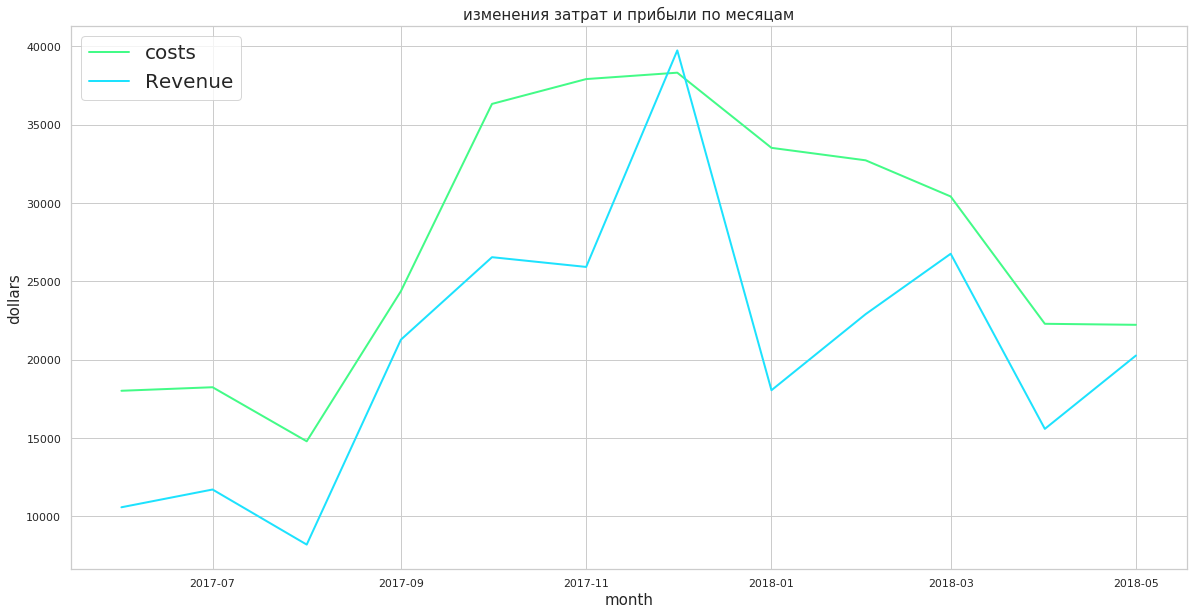

основные метрики при покупке пользователем с устройства в категории touch

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,8.91
1,2017-07-01,9.49
2,2017-08-01,10.80
3,2017-09-01,9.44
4,2017-10-01,8.37
5,2017-11-01,9.29
6,2017-12-01,8.74



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.53,0.57,0.59,0.59,0.60,0.61
2017-07-01,1.00,1.03,1.03,1.04,1.05,1.06
2017-08-01,0.80,0.81,0.82,0.82,0.82,0.82
2017-09-01,0.65,0.87,0.98,1.03,1.08,1.09
2017-10-01,0.67,0.74,0.76,0.76,0.77,0.78
2017-11-01,0.88,0.93,0.95,0.97,1.00,1.00
2017-12-01,0.51,0.54,0.54,0.56,0.56,0.57



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.06,0.06,0.07,0.07,0.07,0.07
2017-07-01,0.11,0.11,0.11,0.11,0.11,0.11
2017-08-01,0.07,0.08,0.08,0.08,0.08,0.08
2017-09-01,0.07,0.09,0.10,0.11,0.11,0.12
2017-10-01,0.08,0.09,0.09,0.09,0.09,0.09
2017-11-01,0.09,0.10,0.10,0.10,0.11,0.11
2017-12-01,0.06,0.06,0.06,0.06,0.06,0.07


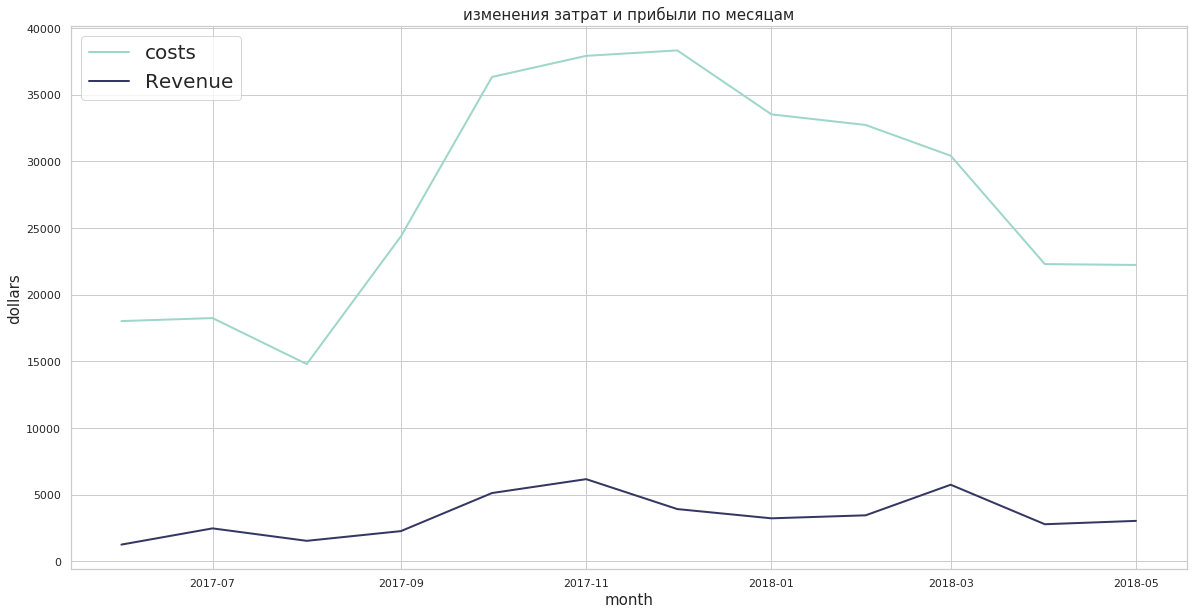

In [35]:
for j in orders_new['Device'].unique():
    data=orders_new.query("Device==@j")
    print("основные метрики при покупке пользователем с устройства в категории {}".format(j))
    print()
    metrics(costs,data)
    grafics(costs,data)

###  По обоим устройствам мы не окупаемся. Однако устройство touch  сильно отстает от desktop. LTV  устройства desktop  колеблится от 4.23  у.е. до 8.02 у.е.  , а окупаемость от 0.48 у.е.  до 0.85 у.е.  , т.е почти все продажи проходят с персонального компьютера. Устройство touch , в свою очередь имеет LTV не выше 1.09 у.е. и окупаемость не выше 0.12. Получается очень малое кол-во покупателей совершило приобретение нашего продукта с мобильного устройства. Это большое упущение и огромный сектор развития. 


### Выведем сколько стоило привлечение одного покупателя из каждого источника и  на сколько окупились расходы на каждую кагорту каждого месяца.

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 1.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,0.56
1,2017-07-01,0.56
2,2017-08-01,0.69
3,2017-09-01,0.58
4,2017-10-01,0.53
5,2017-11-01,0.60
6,2017-12-01,0.53



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.96,1.08,1.20,1.38,1.52,1.72
2017-07-01,1.15,1.30,1.55,1.67,1.69,1.71
2017-08-01,0.81,0.90,0.91,0.96,0.97,0.99
2017-09-01,0.66,0.77,0.85,1.01,1.13,1.16
2017-10-01,0.66,0.76,0.78,0.79,0.81,0.84
2017-11-01,1.05,1.18,1.23,1.31,1.37,1.37
2017-12-01,0.53,0.59,0.65,0.68,0.70,0.72



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,1.71,1.93,2.14,2.46,2.71,3.07
2017-07-01,2.05,2.32,2.77,2.98,3.02,3.05
2017-08-01,1.17,1.30,1.32,1.39,1.41,1.43
2017-09-01,1.14,1.33,1.47,1.74,1.95,2.00
2017-10-01,1.25,1.43,1.47,1.49,1.53,1.58
2017-11-01,1.75,1.97,2.05,2.18,2.28,2.28
2017-12-01,1.00,1.11,1.23,1.28,1.32,1.36


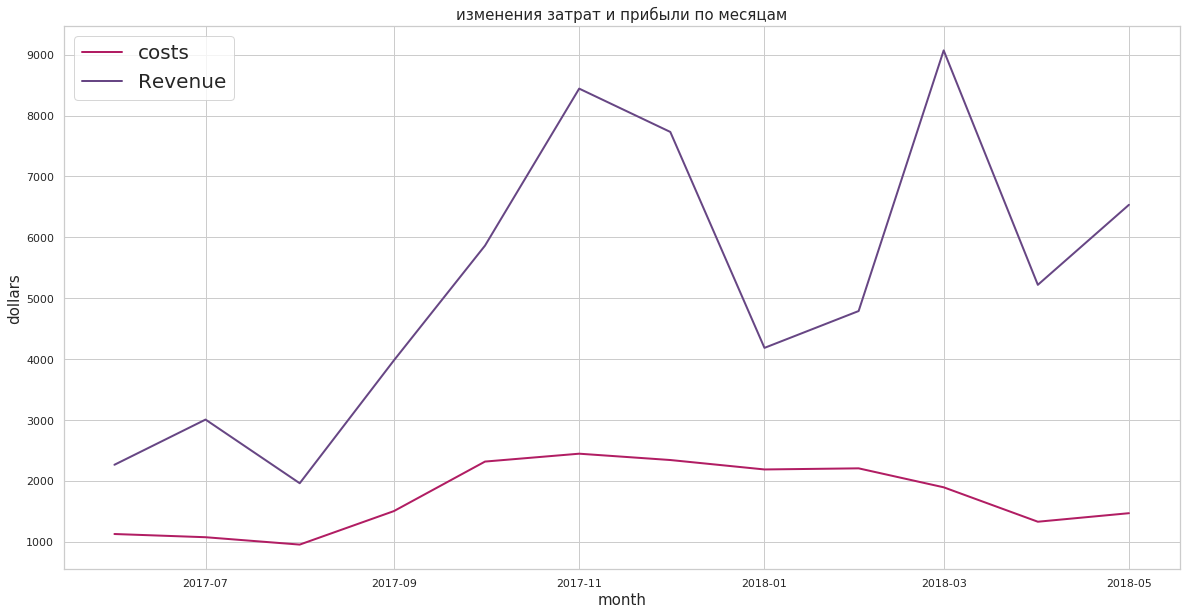

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 2.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,1.20
1,2017-07-01,1.21
2,2017-08-01,1.32
3,2017-09-01,1.16
4,2017-10-01,1.12
5,2017-11-01,1.29
6,2017-12-01,1.12



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,1.02,1.14,1.43,1.71,1.86,1.93
2017-07-01,1.02,1.04,1.10,1.12,1.14,1.14
2017-08-01,0.43,0.48,0.51,0.53,0.54,0.55
2017-09-01,0.57,1.03,1.15,2.92,3.04,3.30
2017-10-01,0.73,0.92,0.96,1.03,1.05,1.07
2017-11-01,0.74,0.83,0.91,0.95,0.97,0.98
2017-12-01,0.85,1.05,1.36,1.83,1.87,1.90



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.85,0.95,1.19,1.42,1.55,1.61
2017-07-01,0.84,0.86,0.91,0.93,0.94,0.94
2017-08-01,0.33,0.36,0.39,0.40,0.41,0.42
2017-09-01,0.49,0.89,0.99,2.52,2.62,2.84
2017-10-01,0.65,0.82,0.86,0.92,0.94,0.96
2017-11-01,0.57,0.64,0.71,0.74,0.75,0.76
2017-12-01,0.76,0.94,1.21,1.63,1.67,1.70


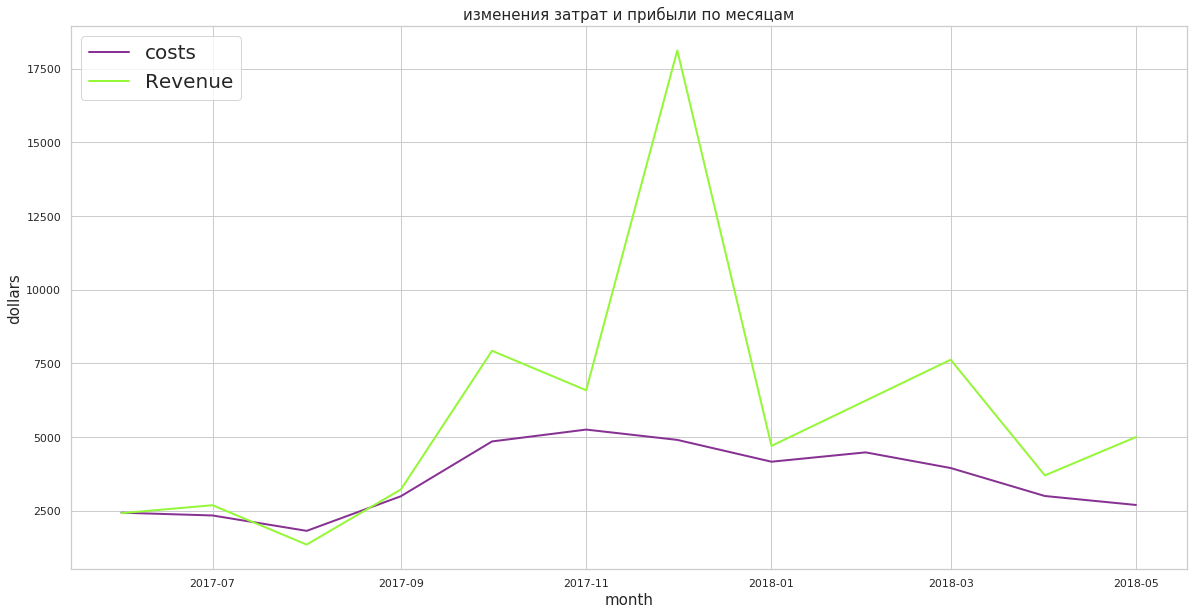

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 3.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,3.82
1,2017-07-01,3.99
2,2017-08-01,4.48
3,2017-09-01,3.86
4,2017-10-01,3.63
5,2017-11-01,4.17
6,2017-12-01,3.70



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,1.09,1.12,1.15,1.15,1.16,1.16
2017-07-01,0.98,1.00,1.03,1.04,1.05,1.08
2017-08-01,0.86,0.87,0.88,0.89,0.90,0.90
2017-09-01,1.02,1.02,1.04,1.12,1.12,1.12
2017-10-01,0.75,0.78,0.79,0.80,0.81,0.82
2017-11-01,0.87,0.92,0.94,0.96,0.97,0.97
2017-12-01,0.74,0.75,0.75,0.76,0.76,0.77



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.29,0.29,0.30,0.30,0.30,0.30
2017-07-01,0.25,0.25,0.26,0.26,0.26,0.27
2017-08-01,0.19,0.19,0.20,0.20,0.20,0.20
2017-09-01,0.26,0.26,0.27,0.29,0.29,0.29
2017-10-01,0.21,0.21,0.22,0.22,0.22,0.23
2017-11-01,0.21,0.22,0.23,0.23,0.23,0.23
2017-12-01,0.20,0.20,0.20,0.21,0.21,0.21


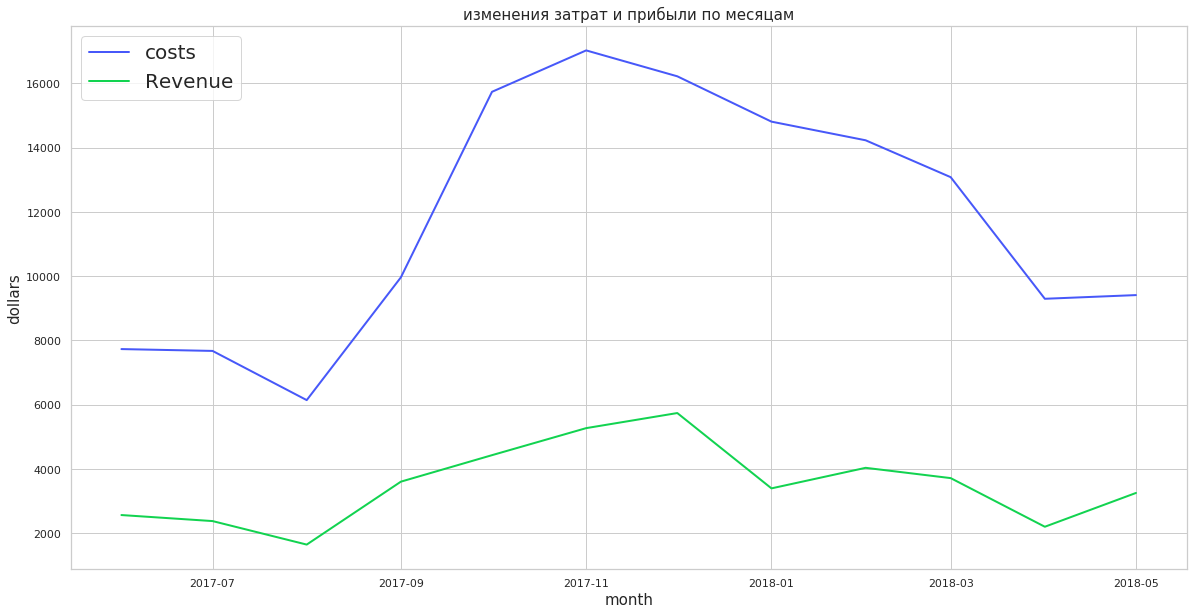

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 5.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,1.29
1,2017-07-01,1.56
2,2017-08-01,1.60
3,2017-09-01,1.49
4,2017-10-01,1.33
5,2017-11-01,1.55
6,2017-12-01,1.34



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.98,1.10,1.20,1.50,1.62,1.68
2017-07-01,1.10,1.19,1.25,1.25,1.26,1.26
2017-08-01,1.09,1.21,1.24,1.29,1.35,1.37
2017-09-01,2.42,2.45,2.46,2.52,2.53,2.57
2017-10-01,0.99,1.00,1.01,1.02,1.05,1.08
2017-11-01,0.66,0.68,0.71,0.84,0.85,0.86
2017-12-01,0.66,0.71,0.74,0.98,1.00,1.02



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.76,0.85,0.93,1.16,1.26,1.30
2017-07-01,0.71,0.76,0.80,0.80,0.81,0.81
2017-08-01,0.68,0.76,0.77,0.81,0.84,0.86
2017-09-01,1.62,1.64,1.65,1.69,1.70,1.72
2017-10-01,0.74,0.75,0.76,0.77,0.79,0.81
2017-11-01,0.43,0.44,0.46,0.54,0.55,0.55
2017-12-01,0.49,0.53,0.55,0.73,0.75,0.76


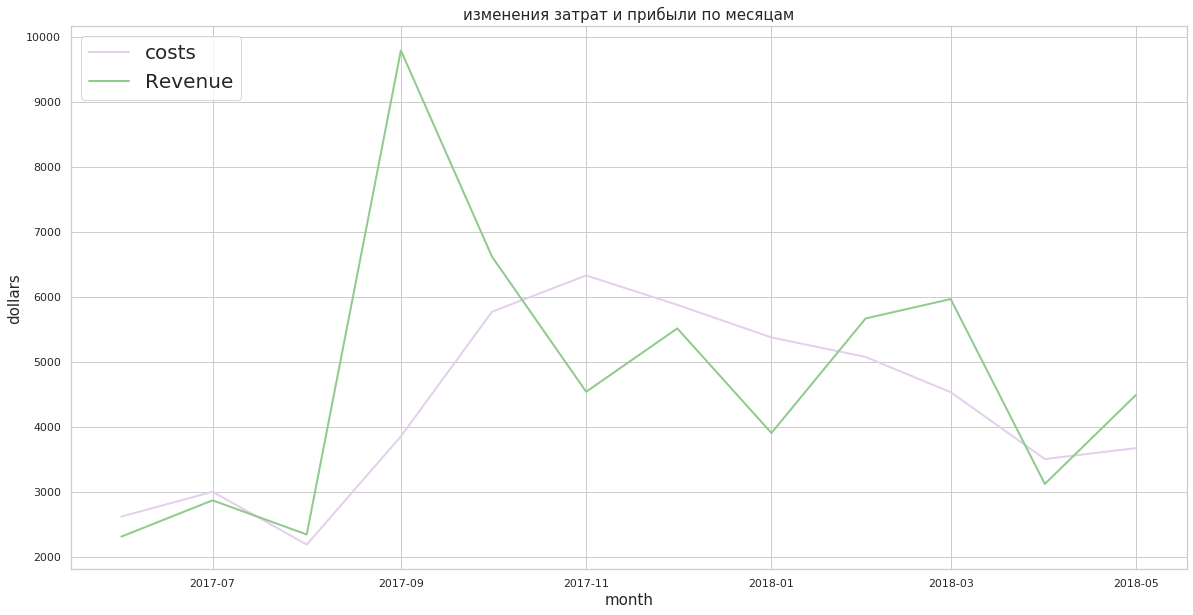

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 4.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,1.74
1,2017-07-01,1.84
2,2017-08-01,2.35
3,2017-09-01,2.01
4,2017-10-01,1.48
5,2017-11-01,1.32
6,2017-12-01,1.75



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.79,0.83,0.87,0.89,0.94,0.98
2017-07-01,1.16,1.19,1.22,1.24,1.25,1.27
2017-08-01,0.98,0.99,1.00,1.00,1.01,1.02
2017-09-01,0.68,0.70,0.73,0.75,0.82,0.83
2017-10-01,0.93,0.98,0.99,1.01,1.01,1.03
2017-11-01,0.96,1.00,1.02,1.06,1.08,1.10
2017-12-01,0.82,0.85,0.87,0.88,0.89,0.91



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.45,0.48,0.50,0.51,0.54,0.56
2017-07-01,0.63,0.65,0.66,0.67,0.68,0.69
2017-08-01,0.42,0.42,0.43,0.43,0.43,0.43
2017-09-01,0.34,0.35,0.36,0.37,0.41,0.41
2017-10-01,0.63,0.66,0.67,0.68,0.68,0.70
2017-11-01,0.73,0.76,0.77,0.80,0.82,0.83
2017-12-01,0.47,0.49,0.50,0.50,0.51,0.52


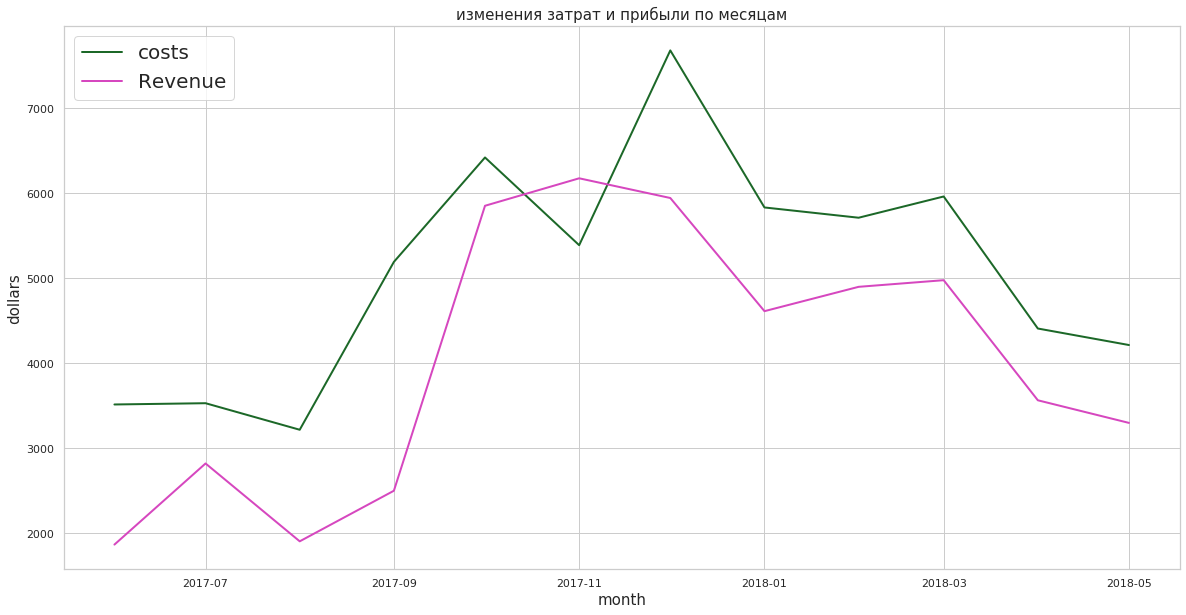

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 9.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,0.14
1,2017-07-01,0.16
2,2017-08-01,0.18
3,2017-09-01,0.16
4,2017-10-01,0.14
5,2017-11-01,0.17
6,2017-12-01,0.15



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.07,0.07,0.08,0.08,0.09,0.09
2017-07-01,0.11,0.13,0.14,0.14,0.14,0.14
2017-08-01,0.09,0.09,0.09,0.09,0.09,0.10
2017-09-01,0.07,0.07,0.08,0.08,0.08,0.08
2017-10-01,0.06,0.07,0.07,0.07,0.07,0.08
2017-11-01,0.07,0.08,0.08,0.08,0.08,0.08
2017-12-01,0.05,0.05,0.05,0.06,0.07,0.08



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.50,0.50,0.57,0.57,0.64,0.64
2017-07-01,0.69,0.81,0.88,0.88,0.88,0.88
2017-08-01,0.50,0.50,0.50,0.50,0.50,0.56
2017-09-01,0.44,0.44,0.50,0.50,0.50,0.50
2017-10-01,0.43,0.50,0.50,0.50,0.50,0.57
2017-11-01,0.41,0.47,0.47,0.47,0.47,0.47
2017-12-01,0.33,0.33,0.33,0.40,0.47,0.53


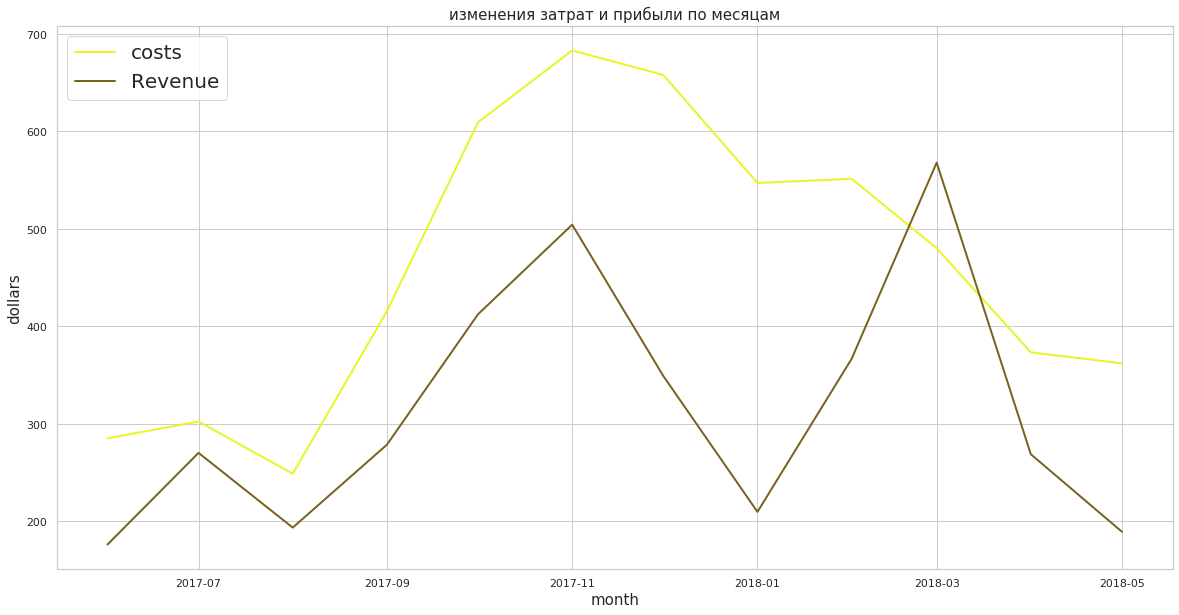

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 10.0

cac по рассматриваемым  источникам равно


,dt_month,cac
0,2017-06-01,0.16
1,2017-07-01,0.17
2,2017-08-01,0.17
3,2017-09-01,0.18
4,2017-10-01,0.14
5,2017-11-01,0.19
6,2017-12-01,0.15



ltv по рассматриваемым  источникам равно


age,0,1,2,3,4,5
first_Ts_month,,,,,,
2017-06-01,0.10,0.11,0.11,0.11,0.11,0.12
2017-07-01,0.06,0.06,0.06,0.06,0.06,0.06
2017-08-01,0.19,0.19,0.19,0.19,0.19,0.19
2017-09-01,0.05,0.05,0.05,0.05,0.05,0.05
2017-10-01,0.10,0.10,0.10,0.10,0.10,0.10
2017-11-01,0.10,0.10,0.10,0.10,0.10,0.10
2017-12-01,0.04,0.04,0.04,0.04,0.04,0.04



romi по рассматриваемым  источникам равно


,0,1,2,3,4,5
dt_month,,,,,,
2017-06-01,0.62,0.69,0.69,0.69,0.69,0.75
2017-07-01,0.35,0.35,0.35,0.35,0.35,0.35
2017-08-01,1.12,1.12,1.12,1.12,1.12,1.12
2017-09-01,0.28,0.28,0.28,0.28,0.28,0.28
2017-10-01,0.71,0.71,0.71,0.71,0.71,0.71
2017-11-01,0.53,0.53,0.53,0.53,0.53,0.53
2017-12-01,0.27,0.27,0.27,0.27,0.27,0.27


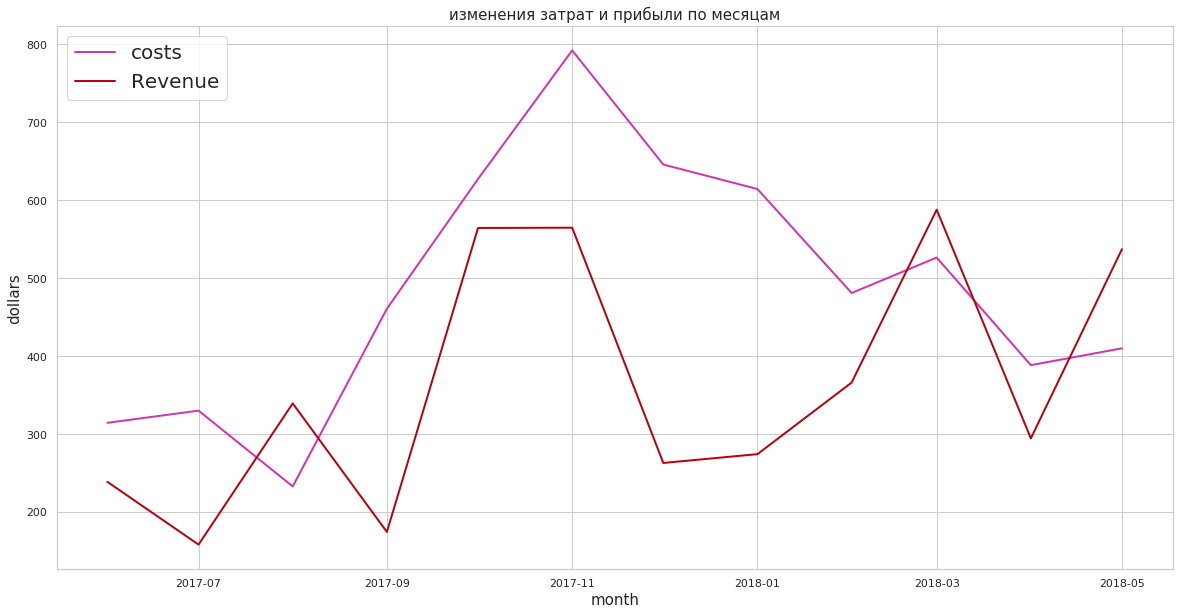

основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории 7.0

cac по рассматриваемым  источникам равно


,dt_month,cac



ltv по рассматриваемым  источникам равно


age,0
first_Ts_month,
2017-08-01,0.0



romi по рассматриваемым  источникам равно


,0
dt_month,


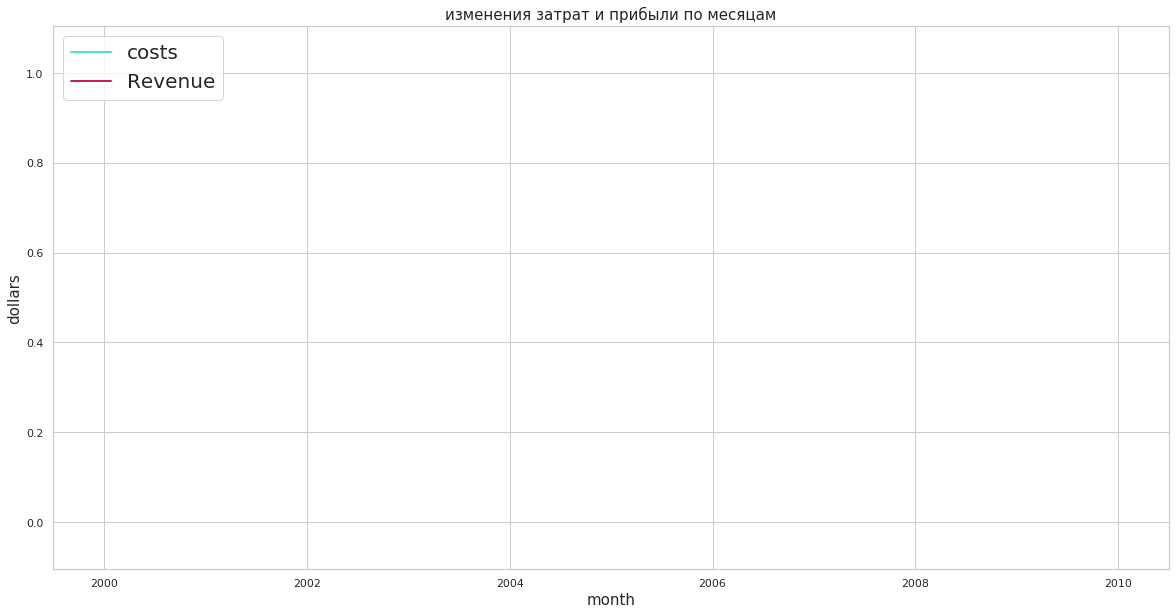

In [36]:
for j in orders_new['source_id'].unique():
    
    data1=costs.query("source_id==@j")
    data2=orders_new.query("source_id==@j")
    print("основные метрики при покупке пользователем пришедшего благодаря рекламному источнику в категории {}".format(j))
    print()
    metrics(data1,data2)
    grafics(data1,data2)

###  Самый эффективный источник рекламы - источник №1. При САС 0.53- 0.69 у.е. ROMI составляет 1.36 -3.07. Все когорты окупаются  почти в два раза за шесть месяцев при низких затратах.
###  Источник №2 эффективен с переменным успехом. При САС 1.12- 1.29 у.е. ROMI колеблится  0.42 -2.84. Однако если посмотреть на графике последующие периоды, то окупаемость этого источника становится очевидной.
###  Источник №3 -дырка в кармане. При самой дорогой стоимости САС 3.63- 4.48 у.е. ROMI составляет 0.55- 1.72.
###  Источник №4 так же имеет крайне плохие показатели. При стоимости САС 1.32- 2.35 у.е. ROMI составляет 0.41- 0.83.
###  Источник №5 (как и источник №2) эффективен с переменным успехом. При САС 1.29- 1.6 у.е. ROMI колеблится  0.55 -1.72.  Окупилось за полгода только две когорты

###  Источник №9 (как и источник №2) ,не смотря на свою дешевизну, совсем не окупился . При САС 0.14- 0.16 у.е. ROMI колеблится  0.47 -0.88.  

###  В источнике № 10 окупилась всего одна когорта. При САС 0.14- 0.19 у.е. ROMI колеблится  0.28 -1.12.

###  Остальные рекламные источники не успели себя показать за первое полугодия и проявят себя потом.


# 3. Вывод

## 1) Оценив Retention Rate можно сделать вывод, что целом величины имеют низкое значение и маленький разброс (Retention Rate до 8,4%). Количество пользователей, которые возвращаются не велико. В подтверждение этого вывода можно отметить, что с каждой новой кагортой уровень рассматриваемого параметра падает. Для увеличения прибыли стоит рассмотреть методику удержания пользователей.
## 2) За шесть месяцев ни одна когорта не окупилась. LTV колеблится от 5.01 у.е. до 9.11 у.е. при CAC в рамках от 7.44 у.е. до 10.8 у.е. Разница почти в два раза, это видно по показателю ROMI , который находится в рамках от 0.47 до 0.97.
## 3)Устройство touch  сильно отстает от desktop. LTV  устройства desktop  колеблится от 4.23  у.е. до 8.02 у.е.  , а окупаемость от 0.48 у.е.  до 0.85 у.е.  , т.е почти все продажи проходят с персонального компьютера. Устройство touch , в свою очередь имеет LTV не выше 1.09 у.е. и окупаемость не выше 0.12. Получается очень малое кол-во покупателей совершило приобретение нашего продукта с мобильного устройства. Это большое упущение и огромный сектор развития. 
## 5)Самые эффективные источники рекламы - источник №1 (При САС 0.53- 0.69 у.е. ROMI составляет 1.36 -3.07) и источник №2 (При САС 1.12- 1.29 у.е. ROMI колеблится 0.42 -2.84).
## 6) Самые НЕ эффективные источники рекламы - источник №3 (При самой дорогой стоимости САС 3.63- 4.48 у.е. ROMI составляет 0.55- 1.72), №4 (При стоимости САС 1.32- 2.35 у.е. ROMI составляет 0.41- 0.83.) и №9 (При САС 0.14- 0.16 у.е. ROMI колеблится 0.47 -0.88). Вероятно, от них имеет смысл отказаться в пользу развития других источников, которые показывают себя с переменным успехом. 
